<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/profile_models/PerPositionGradient_InterpretSPI1ProfileModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Load the model

In [2]:
#Download the keras model
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/9e9880e93fef6c41b5ac40f33142b80305aae4f2/bqtls/profile_model/Spi1ProfileModel_rc.h5 -O Spi1ProfileModel_rc.h5

--2020-09-16 23:32:18--  https://raw.githubusercontent.com/AvantiShri/model_storage/9e9880e93fef6c41b5ac40f33142b80305aae4f2/bqtls/profile_model/Spi1ProfileModel_rc.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2078176 (2.0M) [application/octet-stream]
Saving to: ‘Spi1ProfileModel_rc.h5’

Spi1ProfileModel_rc 100%[===================>]   1.98M  --.-KB/s    in 0.1s    

2020-09-16 23:32:18 (20.7 MB/s) - ‘Spi1ProfileModel_rc.h5’ saved [2078176/2078176]



In [3]:
!pip install keras_genomics # we need to install this because model has revcomp layers

  Created wheel for keras-genomics: filename=keras_genomics-0.1.2.1-cp36-none-any.whl size=10699 sha256=cb374847d350607b07318abfeffdf6fdba3fb938d26a84745f058c1c689390fc
  Stored in directory: /root/.cache/pip/wheels/2a/8e/eb/17f924ed090e1af0773d925dadd42339639e1b87c8ff17dff8
Successfully built keras-genomics


In [4]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import tensorflow as tf
import tensorflow_probability as tfp

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))


#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

#to reload the model, you need to set up a CustomObjectScope
from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,
                        'RevCompConv1D': RevCompConv1D}):
  model = load_model('Spi1ProfileModel_rc.h5')

model.summary()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1346, 4)      0                                            
__________________________________________________________________________________________________
rev_comp_conv1d_1 (RevCompConv1 (None, 1326, 128)    5440        sequence[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1322, 128)    0           rev_comp_conv1d_1[0][0]          
__________________________________________________________________________________________________
rev_comp_conv1d_2 (RevCompConv1 (None, 1322, 128)    24640 

Create a tensor for computing explanations for a particular slice of the output

In [5]:
def get_session(): #returns a tensorflow session
    try:
        if (keras is not None and
            hasattr(keras.backend.tensorflow_backend, "_SESSION")
            and keras.backend.tensorflow_backend._SESSION is not None):
            session = keras.backend.get_session()
        else:
            #tf1
            session = tf.keras.backend.get_session()
    except:
        #tf2
        session = tf.compat.v1.keras.backend.get_session()
    return session


#We meannormalize the logits as per section titled
#"Adjustments for Softmax Layers" in the DeepLIFT paper.
meannormed_logits = (
    model.outputs[1]-
    tf.reduce_mean(model.outputs[1],axis=1)[:,None,:])
#'stop_gradient' will prevent importance from being propagated through
# the softmax operation; we do this because we just want to treat the
# post-softmax probabilities as 'weights' on the different logits,
# without having the network explain how the probabilities themselves
# were derived. This matches what was done in the bpnet paper. However,
# it could be worth contrasting explanations derived with and
# without stop_gradient enabled...
stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
softmax_out = tf.nn.softmax(stopgrad_meannormed_logits,axis=1)

#We create 'slice' variables that represent the part of the input that
# we want to obtain explanations for. shape=() specifies that we have a scalar.
slice_begin_var = tf.Variable(initial_value=0, shape=(),
                          name="slice_begin", dtype=tf.int32)
slice_end_var = tf.Variable(initial_value=1000, shape=(),
                           name="slice_end", dtype=tf.int32)

#Weight the logits according to the softmax probabilities, take the sum for each
# example. This mirrors what was done for the bpnet paper.
weightedsum_sliced_meannormed_logits = tf.reduce_sum(
    (softmax_out*meannormed_logits)[:,slice_begin_var:slice_end_var],
    axis=(1,2))

#We need to initialize the variables that do the slicing before we can use them
session = get_session()
session.run(slice_begin_var.initializer)
session.run(slice_end_var.initializer)

#Define a function that computes the gradients of the target output w.r.t.
# the input
input_grad_tensor = tf.gradients(ys=weightedsum_sliced_meannormed_logits,
                                 xs=[model.inputs[0]])[0]


In [6]:
model.inputs

[<tf.Tensor 'sequence:0' shape=(?, 1346, 4) dtype=float32>,
 <tf.Tensor 'control_logcount:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'control_profile:0' shape=(?, 1000, 2) dtype=float32>]

In [7]:
#This class will be helpful for computing the input gradients for
# different model slices.
class SlicedInputGradComputer(object):
    def __init__(self, model_inputs, input_grad_tensor, slice_begin_var,
                       slice_end_var, session):
        if (isinstance(model_inputs, list)==False):
          print("Wrapping the inputs in a list...")
          model_inputs = [model_inputs]
        self.model_inputs = model_inputs
        self.input_grad_tensor = input_grad_tensor
        self.slice_begin_var = slice_begin_var
        self.slice_end_var = slice_end_var
        self.session = session

    def __call__(self, inputs, region_start, region_end,
                       slice_width, slice_stride):
        slice_start = region_start
        slice_end = slice_start + slice_width
        gradients = []
        while slice_end <= region_end:
            self.update_slices(new_start=slice_start, new_end=slice_end)
            gradients.append(self.compute_grad(inputs=inputs))
            slice_start += slice_stride
            slice_end += slice_stride
        #transpose so that the sample is the first index
        return np.swapaxes(np.array(gradients), 1,0)

    def update_slices(self, new_start, new_end):
        self.session.run(self.slice_begin_var.assign(new_start))
        self.session.run(self.slice_end_var.assign(new_end))

    def compute_grad(self, inputs):
        if len(inputs) > len(self.model_inputs) and len(self.model_inputs)==1:
            print("Wrapping the inputs in a list...")
            inputs = [inputs]
        assert len(inputs)==len(self.model_inputs),\
            ("length of provided list should be "
             +str(len(self.model_inputs))+" for tensors "+str(self.model_inputs)
             +" but got input of length "+str(len(inputs)))
        feed_dict = {}
        for input_tensor, input_val in zip(self.model_inputs, inputs):
            feed_dict[input_tensor] = input_val 
        return self.session.run(self.input_grad_tensor,
                                feed_dict=feed_dict)
    
sliced_input_grad_computer = SlicedInputGradComputer(
    #The control log counts (model.inputs[1]) is not used in computing
    # the output of the profile, so we don't include it among the model inputs
    model_inputs = [model.inputs[0], model.inputs[2]],
    input_grad_tensor=input_grad_tensor,
    slice_begin_var=slice_begin_var,
    slice_end_var=slice_end_var,
    session=session
)

In [8]:
model.outputs

[<tf.Tensor 'task0_logcount/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'task0_profile/add_1:0' shape=(?, 1000, 2) dtype=float32>]

In [9]:
import numpy as np
from scipy.special import softmax

#Let's define some sample sequences
sequences = [
    'TCCCCAAAGACTGCTGTTATCAACTGGGCACAGAAGCACAGGAGGGCAAGCCAGCCCAGCTGTGTGATCCATGCCACACCACGCTGGTCATGCAGAGAAGGCCAGATGCTGCCACAGTTCAGCCTCCAGCTCAGGAAGAAGTCAGGCTTGCAGACGCAGCCTGACCCTAAACGCCGGCCTTCTCAAGCATCCTCACAGCATCCCAAAGAAGGGGCAGAGCAGGCAGAGAGAAACACAAAGTTTATCTAGGGGCACCCTGGTCTTGTGCTTTCCAGCAGGTACACCAAAGCCCTGGAAGTCCCGGAATGACCGTGGTCCTTCAGTGGGCTGGCAGGGTTGTGTGGACTCTCAGGACCCCTCGAGGCAGGTAGGATCAGCGCAGCTGGTGGACCACCCTCCCCTCAGCCCTTGGCTTGGCTGGGGCTGCTGTGGTCTTCCTGCTTAGGGGTTCTGTGATTGGTTTGCTGCCAGGCCTTGCAGGGACCCCCTCTGCCATGGTGCACCCCACCTGTTGCTGGCAGGCTGGTCGCTGGCTATTCTTGACATCTGTCCTTTGGATCTTCACTAGGGCCTTGCTGATCTTATGCATTTTCAGTTCCCATAGGAAAGGGGCCCCGGGCCTCTCCCTGAGCTTCCGGAACCCTGACTCTCCTTAGTAACACTCTCACCAGCGCTTCCTCCCTGCAGGGCCCTGGGTGTCGGCTCACCACACAGACACCAGGCAGAGCCAGCACTACCTGCCCCTGAGAGACGGACCTTTCTTGCCCTAATGCTCACGACCACAAAGGGGACCCATGCACGTCTGCACCCTGGGTCACAGGAGAAAGGTCCCTTGTCCTTGATGAGTCCTCCCCGCCGGAGATGATCAGCACAGAAAGCCCCACAGTTCCACATGTGTTCCTTGATTCCAACATACCTCACAGTTTGCTGACCCCGGAAGTACTGCTGGATTATCAGGGCGGCTCGTCTCTCTCGGAGGAATTTTTTCCTCTGGAGCCAGCCACGCATGTGCTTTTGTACCATAACACAACTCTGCCTCAGTTTATCCAATCGAAGTTTCTCTAAATAAGCCACTTGTCCTGCTCTGAAGAAAATTTTGGTTTTACCAAACTGGTACTGATTAGAATCCTGGAAGAGAAAAATGATATAGTTAGAATTAAAATCTGTCAGATTTTCTATAATACAGTATTTGGAAAAGAGCTTTAGGGATTCAAAGGTGCCAGAAATATTGTGATTTTGACATTTAAGGCAGAAAACTCACATCATGATCTAGAAATGTATACTTTGAGTTGTTTGTTTAAAATTACCCTGGAGGAAGAAATGGGACTTAGGCTGAGGAATCCATT',
    'AACTCACTTCTGTAGGGCTGGCATAAGTCAGGCAGTTCCAGGTACCCACAGGGAGTTGAATAAAATCTATCCAGTGAGTCCTGCAAGACTTCAGGCTCTTTCTCATCCAGCAGCTCCCTGCTGAGCCTGGAAAAGTAGGAAAAGTAAAGAATAAGCCAGGGGGGGCGTTCTcggcgcggagtggagtggagcggagcgggctggtgctgggggcgcggagagcgcagtgctggccggggccgggagcggggccgagcgggagcggagtcgggcgtcgggcccggggagccggggccgggcggggagcagccatggcaccgcggagggtcggggcccgcgccgctgcgggcggcctgggcgccgagtagccgggccgggccggagcgcgggcggcggcggaggcagCTGCGCCCGCGCCTCCTGCCCTCCCAggccccgcgccccgcgcccgggccccggcgATGGTGACACATGCGGCGGCGGCGCGCCAGCGGCAGGACCATGGTTGAGCGCGCCAGCAAGTTCGTGCTGGTGGTGGCGGGCCCGGTGTGCTTCATGCTCATCTTGTACCAGTACGCGGGCCCAGGACTGAGCCTgggcgcgcccggcggcggcgcgccgcccgACGACCTGGACCTGTTCCCCACGCCCGACCCCCACTACGAGAAGAAGCACTACTTCCCGGTCCGCGAGCTGGAGCGCTCGCTGCGCTTCGACATGAAGGGCGACGACGTGATCGTCTTCCTGCACATCCAGAAGACGGGCGGCACCACCTTCGGCCGCCACCTCGTGCAGAACGTACGCCTCGAGGTGCCGTGCGACTGCCGGCCCGGCCAGAAGAAGTGCACCTGCTACCGGCCCAACCGCCGCGAGACTTGGCTCTTCTCCCGCTTCTCCACCGGCTGGAGCTGCGGGCTGCACGCCGACTGGACCGAGCTCACCAACTGCGTGCCCGGCGTGCTGGACCGCCGCGACTCCGCCGCGCTGCGCACGCCCAGGAAGTTCTACTACATCACCCTGCTACGAGACCCCGTGTCCCGCTACCTGAGCGAGTGGCGGCATGTGCAGAGGGGTGCCACGTGGAAGACGTCGTTGCACATGTGTGATGGGCGCACGCCCACGCCTGAGGGGCTGCCGCCCTGCTACGAGGGCACGGACTGGTCGGGCTGCACGCTACAGGAGTTCATGGACTGCCCGTACAACCTGGCCAACAACCGCCAGGTGCGCATGCTGGCCGACCTGAGCCTGGTGGGCTGCTACAACCTGTCCTTCATCCCCGAGGGCAAGCGGGCCCAGCTGCTGCTCGAGAGCGCCAAGAAGAACCTGCGGGGCATGGCCTTCTTCGG',
]

#We define a function to do the one-hot encoding
onehot_mapping = {
    'A': [1,0,0,0],
    'C': [0,1,0,0],
    'G': [0,0,1,0],
    'T': [0,0,0,1],
    'a': [1,0,0,0],
    'c': [0,1,0,0],
    'g': [0,0,1,0],
    't': [0,0,0,1],
}
def one_hot_encode(sequence):
  return np.array([onehot_mapping[x] for x in sequence])

onehot_sequences = np.array([one_hot_encode(x) for x in sequences])

#For the control tracks, we will just supply all-zeros
# for the purpose of this demo notebook.
#For this model, the control profile has shape (1000,2) and the control
# log-counts has a shape of (1,)
CONTROL_PROFILE_SHAPE = (1000, 2)
CONTROL_LOGCOUNT_SHAPE = (1,)
control_profiles = np.zeros(
    tuple([len(sequences)]+list(CONTROL_PROFILE_SHAPE)))
control_logcounts = np.zeros(
    tuple([len(sequences)]+list(CONTROL_LOGCOUNT_SHAPE)))

#compute the normal model outputs, only take the profile because that is
# what we are interested in. Also pass it through the softmax
# to get probabilities
predicted_profiles = softmax(
    model.predict([onehot_sequences, control_logcounts, control_profiles])[1],
    axis=1)

#compute the gradients of the profile at each output position
grads_for_slices = sliced_input_grad_computer(
    inputs=[onehot_sequences, control_profiles],
    region_start=0,
    region_end=1000,
    slice_width=20,
    slice_stride=10
)

In [10]:
!pip install vizsequence #for visualizing the per-position importance

  Created wheel for vizsequence: filename=vizsequence-0.1.1.0-cp36-none-any.whl size=3269 sha256=0ee99fb30d0dc74a39d64a35824d5f45d8de723e8e433096a3498629509a305c
  Stored in directory: /root/.cache/pip/wheels/08/eb/de/6b398b439ba39c278e5c341bdeed57d66280910e096496eaef
Successfully built vizsequence


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Plotting Example Index 0


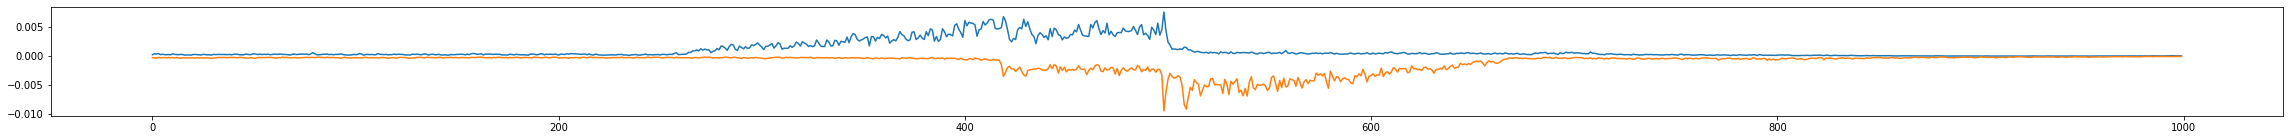

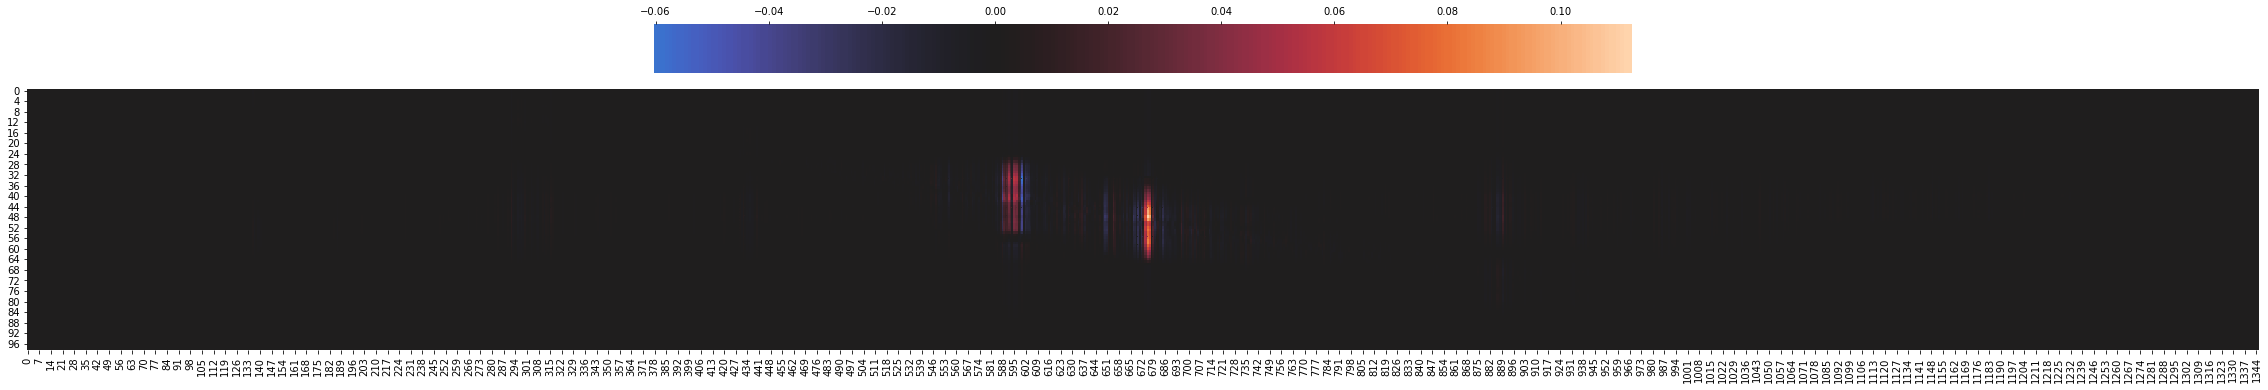

Summing ABSOLUTE importance across all output positions


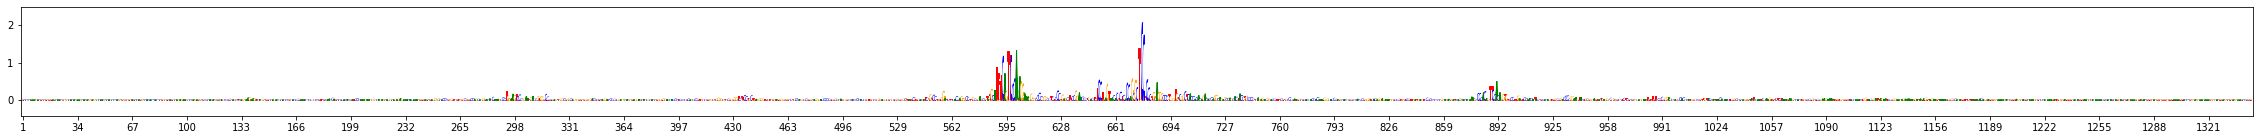

Summing ORIGINAL importance across all output positions


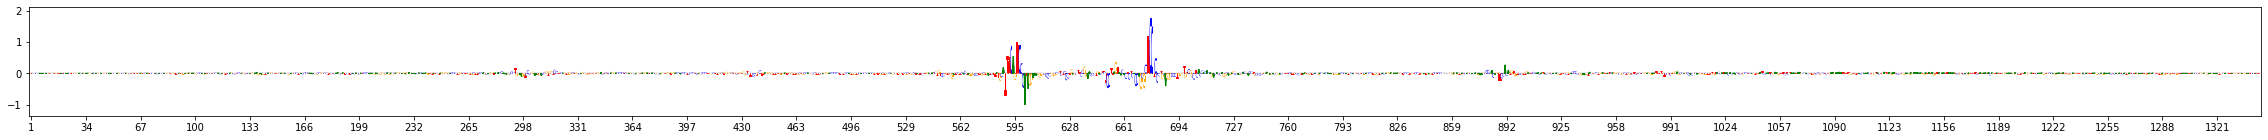

Plotting Example Index 1


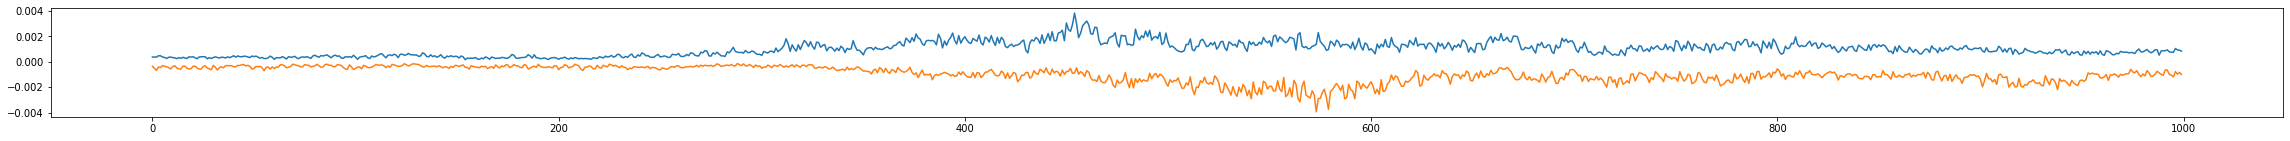

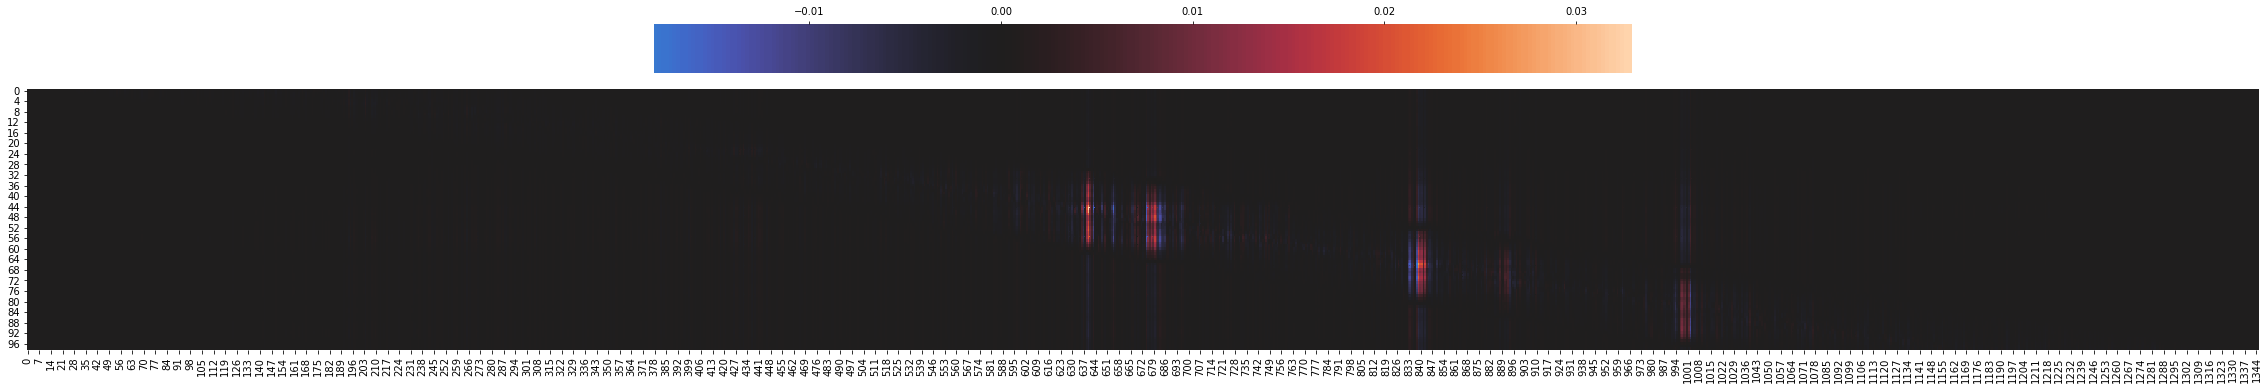

Summing ABSOLUTE importance across all output positions


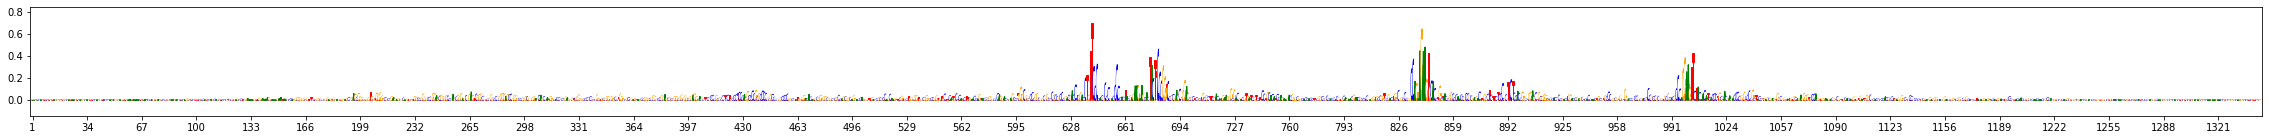

Summing ORIGINAL importance across all output positions


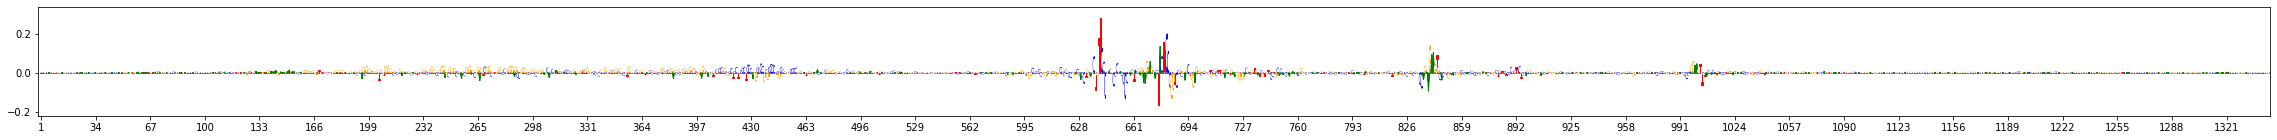

In [11]:
import vizsequence

#For visualization purposes, let's project the gradients onto the one-hot
# encoded sequence and then sum across the ACGT axis (axis -1) to get
# a gradient at each position
perposition_grads = np.sum(grads_for_slices*onehot_sequences[:,None], axis=-1)
#At each position, we can sum up the absolute value of the per-position gradients
sumacrossout_abs_perposition_grads = np.sum(np.abs(perposition_grads), axis=1)
#For comparison, we'll also contrast to what the gradients are when we don't
# take the absolute value prior to summing
sumacrossout_perposition_grads = np.sum(perposition_grads, axis=1)

import seaborn as sns
from matplotlib import pyplot as plt

def viz_example(example_idx):
  print("Plotting Example Index", example_idx)
  plt.figure(figsize=(40,2))
  plt.plot(predicted_profiles[example_idx][:,0])
  plt.plot(-predicted_profiles[example_idx][:,1])
  plt.show()
  plt.figure(figsize=(40,6))
  sns.heatmap(perposition_grads[example_idx], center=0,
              cbar_kws = dict(use_gridspec=False,location="top"))
  plt.show()
  print("Summing ABSOLUTE importance across all output positions")
  vizsequence.plot_weights(
      sumacrossout_abs_perposition_grads[example_idx][:,None]
      *onehot_sequences[example_idx],
      figsize=(40,2))
  print("Summing ORIGINAL importance across all output positions")
  vizsequence.plot_weights(
      sumacrossout_perposition_grads[example_idx][:,None]
      *onehot_sequences[example_idx],
      figsize=(40,2))

viz_example(example_idx=0)
viz_example(example_idx=1)